In [ ]:
import numpy as np
import time

import numpy.linalg as la
import matplotlib.pyplot as plt


class Trainer:
    def __init__(self, grad_func, loss_func, t_max=np.inf, it_max=np.inf, output_size=500, tolerance=0):
        if t_max is np.inf and it_max is np.inf:
            it_max = 100
            print('The number of iterations is set to 100.')
        self.grad_func = grad_func
        self.loss_func = loss_func
        self.t_max = t_max
        self.it_max = it_max
        self.output_size = output_size
        self.first_run = True
        self.tolerance = tolerance
        self.losses = None

    def run(self, w0):
        if self.first_run:
            self.init_run(w0)
        else:
            self.ts = list(self.ts)
            self.its = list(self.its)
            self.ws = list(self.ws)
        self.first_run = False
        while (self.it < self.it_max) and (time.time() - self.t_start < self.t_max):
            sufficiently_big_gradient = self.compute_grad()
            if not sufficiently_big_gradient:
                break
            self.estimate_stepsize()
            self.w = self.step()

            self.save_checkpoint()

        self.ts = np.array(self.ts)
        self.its = np.array(self.its)
        self.ws = np.array(self.ws)

    def compute_grad(self):
        self.grad = self.grad_func(self.w)
        return la.norm(self.grad) > self.tolerance

    def estimate_stepsize(self):
        pass

    def step(self):
        pass

    def init_run(self, w0):
        self.d = len(w0)
        self.w = w0.copy()
        self.ws = [w0.copy()]
        self.its = [0]
        self.ts = [0]
        self.it = 0
        self.t = 0
        self.t_start = time.time()
        self.time_progress = 0
        self.iterations_progress = 0
        self.max_progress = 0

    def save_checkpoint(self, first_iterations=10):
        self.it += 1
        self.t = time.time() - self.t_start
        self.time_progress = int((self.output_size - first_iterations) * self.t / self.t_max)
        self.iterations_progress = int((self.output_size - first_iterations) * (self.it / self.it_max))
        if (max(self.time_progress, self.iterations_progress) > self.max_progress) or (self.it <= first_iterations):
            self.update_logs()
        self.max_progress = max(self.time_progress, self.iterations_progress)

    def update_logs(self):
        self.ws.append(self.w.copy())
        self.ts.append(self.t)
        self.its.append(self.it)

    def compute_loss_on_iterates(self):
        self.losses = np.array([self.loss_func(w) for w in self.ws])

    def plot_losses(self, label='', marker=',', f_star=None, markevery=None):
        if self.losses is None:
            self.compute_loss_on_iterates()
        if f_star is None:
            f_star = np.min(self.losses)
        if markevery is None:
            markevery = max(1, len(self.losses) // 20)
        plt.plot(self.its, self.losses - f_star, label=label, marker=marker, markevery=markevery)

#Optimizer

In [ ]:
import numpy as np

import numpy.linalg as la




class Gd(Trainer):
    def __init__(self, lr, *args, **kwargs):
        super(Gd, self).__init__(*args, **kwargs)
        self.lr = lr

    def step(self):
        return self.w - self.lr * self.grad

    def init_run(self, *args, **kwargs):
        super(Gd, self).init_run(*args, **kwargs)


class Nesterov(Trainer):
    def __init__(self, lr, strongly_convex=False, mu=0, *args, **kwargs):
        super(Nesterov, self).__init__(*args, **kwargs)
        self.lr = lr
        if mu < 0:
            raise ValueError("Invalid mu: {}".format(mu))
        if strongly_convex and mu == 0:
            raise ValueError("""Mu must be larger than 0 for strongly_convex=True,
                             invalid value: {}""".format(mu))
        if strongly_convex:
            self.mu = mu
            kappa = (1/self.lr)/self.mu
            self.momentum = (np.sqrt(kappa)-1) / (np.sqrt(kappa)+1)
        self.strongly_convex = strongly_convex

    def step(self):
        if not self.strongly_convex:
            alpha_new = 0.5 * (1 + np.sqrt(1 + 4 * self.alpha ** 2))
            self.momentum = (self.alpha - 1) / alpha_new
            self.alpha = alpha_new
        self.w_nesterov_old = self.w_nesterov.copy()
        self.w_nesterov = self.w - self.lr * self.grad
        return self.w_nesterov + self.momentum * (self.w_nesterov - self.w_nesterov_old)

    def init_run(self, *args, **kwargs):
        super(Nesterov, self).init_run(*args, **kwargs)
        self.w_nesterov = self.w.copy()
        self.alpha = 1.


class Adgd(Trainer):
    def __init__(self, eps=0.0, lr0=None, *args, **kwargs):
        if not 0.0 <= eps:
            raise ValueError("Invalid eps: {}".format(eps))
        super(Adgd, self).__init__(*args, **kwargs)
        self.eps = eps
        self.lr0 = lr0

    def estimate_stepsize(self):
        L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)
        if np.isinf(self.theta):
            lr_new = 0.5 / L
        else:
            lr_new = min(np.sqrt(1 + self.theta) * self.lr, self.eps / self.lr + 0.5 / L)
        self.theta = lr_new / self.lr
        self.lr = lr_new

    def step(self):
        self.w_old = self.w.copy()
        self.grad_old = self.grad.copy()
        return self.w - self.lr * self.grad

    def init_run(self, *args, **kwargs):
        super(Adgd, self).init_run(*args, **kwargs)
        self.theta = np.inf
        grad = self.grad_func(self.w)
        if self.lr0 is None:
            self.lr0 = 1e-10
        self.lr = self.lr0
        self.lrs = [self.lr]
        self.w_old = self.w.copy()
        self.grad_old = grad
        self.w -= self.lr * grad
        self.save_checkpoint()

    def update_logs(self):
        super(Adgd, self).update_logs()
        self.lrs.append(self.lr)


class AdgdAccel(Trainer):
    def __init__(self, a_lr=0.5, a_mu=0.5, b_lr=0.5, b_mu=0.5, *args, **kwargs):
        super(AdgdAccel, self).__init__(*args, **kwargs)
        self.a_lr = a_lr
        self.a_mu = a_mu
        self.b_lr = b_lr
        self.b_mu = b_mu

    def estimate_stepsize(self):
        L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)
        lr_new = min(np.sqrt(1 + self.a_lr * self.theta_lr) * self.lr, self.b_lr / L)
        self.theta_lr = lr_new / self.lr
        self.lr = lr_new
        mu_new = min(np.sqrt(1 + self.a_mu * self.theta_mu) * self.mu, self.b_lr * L)
        self.theta_mu = mu_new / self.mu
        self.mu = mu_new

    def step(self):
        self.w_old = self.w.copy()
        self.grad_old = self.grad.copy()
        momentum = (np.sqrt(1 / self.lr) - np.sqrt(self.mu)) / (np.sqrt(1 / self.lr) + np.sqrt(self.mu))
        self.w_nesterov_old = self.w_nesterov.copy()
        self.w_nesterov = self.w - self.lr * self.grad
        return self.w_nesterov + momentum * (self.w_nesterov - self.w_nesterov_old)

    def init_run(self, *args, **kwargs):
        super(AdgdAccel, self).init_run(*args, **kwargs)
        self.theta_lr = np.inf
        self.theta_mu = np.inf
        grad = self.grad_func(self.w)
        # The first estimate is normalized gradient with a small coefficient
        self.lr = 1e-5 / la.norm(grad)
        self.lrs = [self.lr]
        self.mu = 1 / self.lr
        self.w_old = self.w.copy()
        self.w_nesterov = self.w.copy()
        self.grad_old = grad
        self.w -= self.lr * grad
        self.save_checkpoint()

    def update_logs(self):
        super(AdgdAccel, self).update_logs()
        self.lrs.append(self.lr)


class Adagrad(Trainer):
    def __init__(self, primal_dual=False, eta=1, delta=0, *args, **kwargs):
        super(Adagrad, self).__init__(*args, **kwargs)
        self.primal_dual = primal_dual
        self.eta = eta
        self.delta = delta

    def estimate_stepsize(self):
        self.s = np.sqrt(self.s ** 2 + self.grad ** 2)
        self.inv_lr = self.delta + self.s
        assert len(self.inv_lr) == len(self.w)

    def step(self):
        if self.primal_dual:
            self.sum_grad += self.grad
            return self.w0 - self.eta * np.divide(self.sum_grad, self.inv_lr, out=np.zeros_like(self.inv_lr), where=self.inv_lr != 0)
        else:
            return self.w - self.eta * np.divide(self.grad, self.inv_lr, out=np.zeros_like(self.inv_lr), where=self.inv_lr != 0)

    def init_run(self, *args, **kwargs):
        super(Adagrad, self).init_run(*args, **kwargs)
        self.w0 = self.w.copy()
        self.s = np.zeros(len(self.w))
        self.sum_grad = np.zeros(self.d)


class MirrorDescent(Trainer):
    def __init__(self, lr, mirror_step, *args, **kwargs):
        super(MirrorDescent, self).__init__(*args, **kwargs)
        self.lr = lr
        self.mirror_step = mirror_step

    def step(self):
        return self.mirror_step(self.w, self.lr, self.grad)

    def init_run(self, *args, **kwargs):
        super(MirrorDescent, self).init_run(*args, **kwargs)


class Bb(Trainer):
    def __init__(self, lr0=1, option='1', *args, **kwargs):
        if not 0.0 < lr0:
            raise ValueError("Invalid lr0: {}".format(lr0))
        super(Bb, self).__init__(*args, **kwargs)
        self.lr0 = lr0
        self.option = option

    def estimate_stepsize(self):
        if self.option is '1':
            L = (self.w-self.w_old) @ (self.grad-self.grad_old) / la.norm(self.w-self.w_old)**2
        else:
            L = la.norm(self.grad-self.grad_old)**2 / ((self.grad-self.grad_old) @ (self.w-self.w_old))
        self.lr = self.lr0/L

    def step(self):
        self.grad = self.grad_func(self.w)
        self.estimate_stepsize()
        self.w_old = self.w.copy()
        self.grad_old = self.grad.copy()
        return self.w - self.lr*self.grad

    def init_run(self, *args, **kwargs):
        super(Bb, self).init_run(*args, **kwargs)
        self.lrs = []
        self.theta = np.inf
        grad = self.grad_func(self.w)
        # The first estimate is normalized gradient with a small coefficient
        self.lr = 1 / la.norm(grad)
        self.w_old = self.w.copy()
        self.grad_old = grad
        self.w -= self.lr * grad
        self.save_checkpoint()

    def update_logs(self):
        super(Bb, self).update_logs()
        self.lrs.append(self.lr)


class Polyak(Trainer):
    def __init__(self, f_opt=0, lr_min=0.0, *args, **kwargs):
        if lr_min < 0:
            raise ValueError("Invalid lr_min: {}".format(lr_min))
        super(Polyak, self).__init__(*args, **kwargs)
        self.lr_min = lr_min
        self.f_opt = f_opt

    def estimate_stepsize(self):
        f = self.loss_func(self.w)
        self.lr = max(self.lr_min, (f-self.f_opt) / la.norm(self.grad)**2)

    def step(self):
        self.grad = self.grad_func(self.w)
        self.estimate_stepsize()
        return self.w - self.lr * self.grad

    def init_run(self, *args, **kwargs):
        super(Polyak, self).init_run(*args, **kwargs)
        self.w_ave = self.w.copy()
        self.ws_ave = [self.w_ave.copy()]
        self.lr_sum = 0
        self.lrs = []

    def update_logs(self):
        super(Polyak, self).update_logs()
        self.lrs.append(self.lr)
        self.ws_ave.append(self.w_ave.copy())


class Armijo(Trainer):
    def __init__(self, backtracking=0.5, armijo_const=0.5, lr0=None, *args, **kwargs):
        if lr0 < 0:
            raise ValueError("Invalid lr0: {}".format(lr0))
        super(Armijo, self).__init__(*args, **kwargs)
        self.lr = lr0
        self.backtracking = backtracking
        self.armijo_const = armijo_const

    def estimate_stepsize(self):
        f = self.loss_func(self.w)
        lr = self.lr / self.backtracking
        w_new = self.w - lr * self.grad
        f_new = self.loss_func(w_new)
        armijo_condition = f_new <= f - self.lr * self.armijo_const * la.norm(self.grad)**2
        while not armijo_condition:
            lr *= self.backtracking
            w_new = self.w - lr * self.grad
            f_new = self.loss_func(w_new)
            armijo_condition = f_new <= f - lr * self.armijo_const * la.norm(self.grad)**2
            self.it += 1

        self.lr = lr

    def step(self):
        self.grad = self.grad_func(self.w)
        self.estimate_stepsize()
        return self.w - self.lr * self.grad

    def init_run(self, *args, **kwargs):
        super(Armijo, self).init_run(*args, **kwargs)
        self.w_ave = self.w.copy()
        self.ws_ave = [self.w_ave.copy()]
        self.lr_sum = 0
        self.lrs = []

    def update_logs(self):
        super(Armijo, self).update_logs()
        self.lrs.append(self.lr)
        self.ws_ave.append(self.w_ave.copy())


class NestLine(Trainer):
    def __init__(self, lr0=1, mu=0, backtracking=0.5, tolerance=0., *args, **kwargs):
        super(NestLine, self).__init__(*args, **kwargs)
        self.lr = lr0
        if mu < 0:
            raise ValueError("Invalid mu: {}".format(mu))
        self.mu = mu
        self.backtracking = backtracking
        self.tolerance = tolerance

    def condition(self, y, w_new):
        grad_new = self.grad_func(w_new)
        return grad_new @ (y-w_new) >= self.lr * la.norm(grad_new)**2 - self.tolerance

    def step(self):
        self.lr = self.lr / self.backtracking
        # Find a from quadratic equation a^2/(A+a) = 2*lr*(1 + mu*A)
        discriminant = (self.lr * (1+self.mu*self.A))**2 + self.A * self.lr * (1+self.mu*self.A)
        a = self.lr * (1+self.mu*self.A) + np.sqrt(discriminant)
        y = (self.A*self.w + a*self.v) / (self.A+a)
        gradient = self.grad_func(y)
        w_new = y - self.lr * gradient
        nest_condition_met = self.condition(y, w_new)
        self.it += 1

        it_extra = 0
        while not nest_condition_met and it_extra < 2 * self.it_max:
            self.lr *= self.backtracking
            discriminant = (self.lr * (1+self.mu*self.A))**2 + self.A * self.lr * (1+self.mu*self.A)
            a = self.lr * (1+self.mu*self.A) + np.sqrt(discriminant)
            y = self.A / (self.A+a) * self.w + a / (self.A+a) * self.v
            gradient = self.grad_func(y)
            w_new = y - self.lr * gradient
            nest_condition_met = self.condition(y, w_new)
            it_extra += 2
            if self.lr * self.backtracking == 0:
                break

        self.it += it_extra
        self.w = w_new
        self.A += a
        self.grad = self.grad_func(self.w)
        self.v -= a * self.grad

        return self.w

    def init_run(self, *args, **kwargs):
        super(NestLine, self).init_run(*args, **kwargs)
        self.A = 0
        self.v = self.w.copy()

<>:236: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:236: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipykernel_2186/1023728118.py:236: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if self.option is '1':


In [3]:
class GDA(Trainer):
  def __init__(self, k, sigma, lr,  *args, **kwargs):
    super(GDA, self).__init__(*args, **kwargs)
    self.lr = lr
    self.k = k
    self.sigma = sigma
  def step(self):
      self.w = self.w - self.lr * self.grad
      # self.estimate_stepsize()
      return self.w
  def estimate_stepsize(self):
      f = self.loss_func(self.w)
      w_new = self.w - self.lr * self.grad
      e = np.sum(self.grad* (self.w - w_new))
      dl = self.loss_func(w_new) - self.loss_func(self.w) + self.sigma*e
      # print(dl)
      if dl <= 0:
        self.lr = self.lr

      else:
        self.lr = self.k*self.lr
        print(f'lr:{self.lr}')
  def init_run(self, *args, **kwargs):
    super(GDA, self).init_run(*args, **kwargs)
    self.w_pre = self.w.copy()
    grad = self.grad_func(self.w)
    self.lrs = [self.lr]
    self.grad_old = grad
    self.w -= self.lr * grad
    e = np.sum(grad* (self.w_pre - self.w))
    dl = self.loss_func(self.w) - self.loss_func(self.w_pre) + self.sigma*e
    # print(dl)
    if dl <= 0:
        self.lr = self.lr
    else:
        self.lr = self.k*self.lr
  def update_logs(self):
        super(GDA, self).update_logs()
        self.lrs.append(self.lr)


#Loss_Functions

In [ ]:
import scipy
import numpy as np

import numpy.linalg as la
from sklearn.utils.extmath import safe_sparse_dot

def safe_sparse_add(a, b):
    if scipy.sparse.issparse(a) and scipy.sparse.issparse(b):
        # both are sparse, keep the result sparse
        return a + b
    else:
        # on of them is non-sparse, convert
        # everything to dense.
        if scipy.sparse.issparse(a):
            a = a.toarray()
            if a.ndim == 2 and b.ndim == 1:
                b.ravel()
        elif scipy.sparse.issparse(b):
            b = b.toarray()
            if b.ndim == 2 and a.ndim == 1:
                b = b.ravel()
        return a + b


def logsig(x):
    out = np.zeros_like(x)
    idx0 = x < -33
    out[idx0] = x[idx0]
    idx1 = (x >= -33) & (x < -18)
    out[idx1] = x[idx1] - np.exp(x[idx1])
    idx2 = (x >= -18) & (x < 37)
    out[idx2] = -np.log1p(np.exp(-x[idx2]))
    idx3 = x >= 37
    out[idx3] = -np.exp(-x[idx3])
    return out


def logistic_loss(w, X, y, l2, reg=True):
   
    z = np.dot(X, w)
    y = np.asarray(y)
    return np.mean((1-y)*z - logsig(z)) + l2/2 * la.norm(w)**2


def logistic_gradient(w, X, y_, l2, normalize=True):
    y = (y_+1) / 2 if -1 in y_ else y_
    activation = scipy.special.expit(safe_sparse_dot(X, w, dense_output=True).ravel())
    grad = safe_sparse_add(X.T.dot(activation - y) / X.shape[0], l2 * w)
    grad = np.asarray(grad).ravel()
    if normalize:
        return grad
    return grad * len(y)


def cubic_loss(w, H, g, M, scale=1):
    return w@g + 0.5*H@w@w + scale*M/6*la.norm(w)**3


def cubic_gradient(w, H, g, M, scale=1):
    return (g+H@w)/scale + M/2*w*la.norm(w)

#Losgistic regression

In [5]:
!pip install wget


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
import wget
url = "https://github.com/ymalitsky/adaptive_GD/blob/master/datasets/w8a?raw=true"
wget.download(url, out='w8a.txt')

'w8a.txt'

In [7]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file


sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
dataset = 'mushrooms'
data_path = "mushrooms.text"
if dataset == 'covtype':
    data_path += '.bz2'

if dataset == 'covtype':
    it_max = 10000
elif dataset == 'w8a':
    it_max = 8000
else:
    it_max = 4000

def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))


data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Loss functions support only labels from {0, 1}
    y -= 1
if (np.unique(y) == [-1, 1]).all():
    y = (y+1) / 2
n, d = X.shape
L = logistic_smoothness(X)
l2 = L / n if dataset == 'covtype' else L / (10 * n)
w0 = np.zeros(d)

def loss_func(w):
    return logistic_loss(w, X, y, l2)

def grad_func(w):
    return logistic_gradient(w, X, y, l2)

In [8]:
X[0]

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [ ]:
import torch
import numpy as np

from torch.optim.optimizer import Optimizer, required


class Adsgd(Optimizer):
    def __init__(self, params, lr=0.2, amplifier=0.02, theta=1, damping=1, eps=1e-5, weight_decay=0):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid initial learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, amplifier=amplifier, theta=theta, damping=damping,
                        eps=eps, weight_decay=weight_decay)
        super(Adsgd, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adsgd, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('lr', 0.2)
            group.setdefault('amplifier', 0.02)
            group.setdefault('damping', 1)
            group.setdefault('theta', 1)

    def compute_dif_norms(self, prev_optimizer=required):
        for group, prev_group in zip(self.param_groups, prev_optimizer.param_groups):
            grad_dif_norm = 0
            param_dif_norm = 0
            for p, prev_p in zip(group['params'], prev_group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                prev_d_p = prev_p.grad.data
                grad_dif_norm += (d_p - prev_d_p).norm().item() ** 2
                param_dif_norm += (p.data - prev_p.data).norm().item() ** 2
            group['grad_dif_norm'] = np.sqrt(grad_dif_norm)
            group['param_dif_norm'] = np.sqrt(param_dif_norm)

    def step(self, closure=None):

        # TODO: use closure to compute gradient difference
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            eps = group['eps']
            lr = group['lr']
            damping = group['damping']
            amplifier = group['amplifier']
            theta = group['theta']
            grad_dif_norm = group['grad_dif_norm']
            param_dif_norm = group['param_dif_norm']
            if param_dif_norm > 0 and grad_dif_norm > 0:
                lr_new = min(lr * np.sqrt(1 + amplifier * theta), param_dif_norm / (damping * grad_dif_norm)) + eps
            else:
                lr_new = lr * np.sqrt(1 + amplifier * theta)
            theta = lr_new / lr
            group['theta'] = theta
            group['lr'] = lr_new
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if group['weight_decay'] != 0:
                    d_p.add_(group['weight_decay'], p.data)
                p.data.add_(d_p, alpha=-lr_new)
        return loss

In [10]:
ar = Armijo(lr0=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ar.run(w0=w0)

In [11]:
L

np.float64(2.586214233904432)

In [12]:

gda1 = GDA(k=0.75, sigma= 1/L, lr=1000, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gda1.run(w0)

lr:562.5
lr:421.875
lr:316.40625
lr:237.3046875
lr:177.978515625


lr:133.48388671875
lr:100.1129150390625


In [13]:

gda2 = GDA(k=0.85, sigma= 1/L, lr=1000, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gda2.run(w0)

lr:722.5
lr:614.125
lr:522.00625
lr:443.7053125
lr:377.149515625
lr:320.57708828125
lr:272.4905250390625
lr:231.61694628320313
lr:196.87440434072266
lr:167.34324368961427
lr:142.2417571361721
lr:120.9054935657463
lr:102.76966953088436
lr:87.3542191012517


In [14]:

gda3 = GDA(k=0.95, sigma= 1/L, lr=1000, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gda3.run(w0)

lr:902.5
lr:857.375
lr:814.5062499999999
lr:773.7809374999998
lr:735.0918906249998
lr:698.3372960937497
lr:663.4204312890622
lr:630.2494097246091
lr:598.7369392383787
lr:568.8000922764597
lr:540.3600876626367
lr:513.3420832795049
lr:487.6749791155296
lr:463.29123015975307
lr:440.1266686517654
lr:418.1203352191771
lr:397.2143184582182
lr:377.3536025353073
lr:358.4859224085419
lr:340.5616262881148
lr:323.533544973709
lr:307.35686772502356
lr:291.98902433877237
lr:277.38957312183373
lr:263.52009446574203
lr:250.3440897424549
lr:237.82688525533214
lr:225.93554099256554
lr:214.63876394293726
lr:203.9068257457904
lr:193.71148445850088
lr:184.02591023557582
lr:174.82461472379703
lr:166.08338398760716
lr:157.7792147882268
lr:149.89025404881545
lr:142.39574134637468
lr:135.27595427905592
lr:128.5121565651031
lr:122.08654873684794
lr:115.98222130000555
lr:110.18311023500526
lr:104.673954723255
lr:99.44025698709224
lr:94.46824413773763
lr:89.74483193085074


In [15]:
gd = Gd(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gd.run(w0=w0)

In [16]:
nest = Nesterov(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest.run(w0=w0)

In [17]:
# nest_str = Nesterov(lr=1 / L, strongly_convex=True, mu=l2, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
# nest_str.run(w0=w0)

In [18]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
adgd.run(w0=w0)

In [19]:
ad_acc = AdgdAccel(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ad_acc.run(w0=w0)

In [20]:
nest_ls = NestLine(lr0=1 / L, mu=0, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest_ls.run(w0=w0)

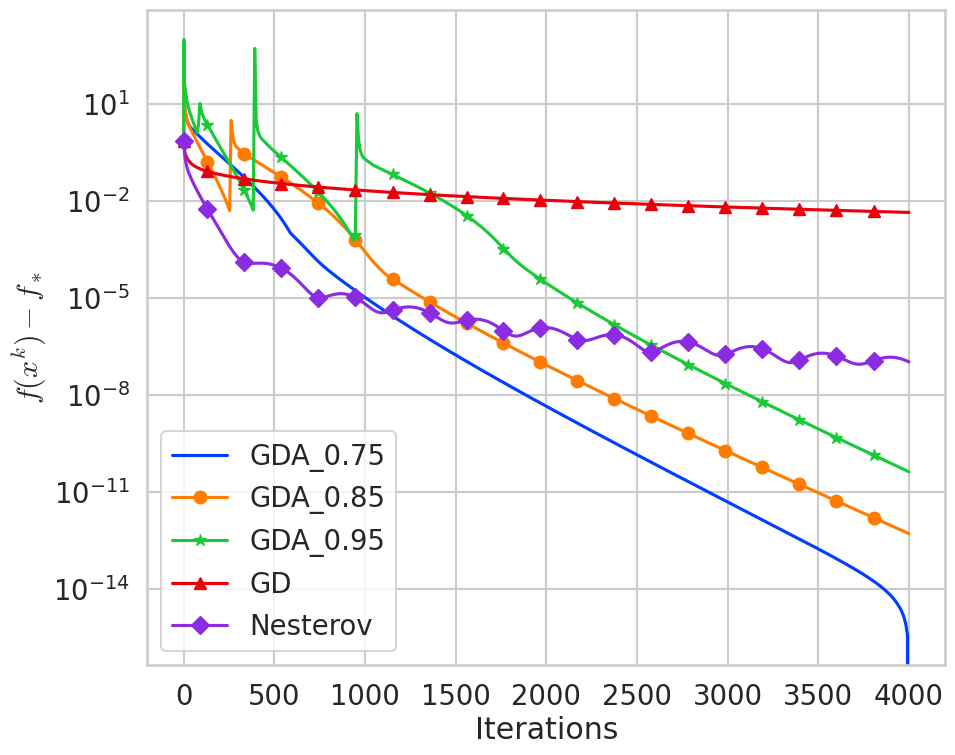

In [21]:
optimizers = [gda1,gda2, gda3, gd, nest]
markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(10, 8))
labels = ['GDA_0.75','GDA_0.85', 'GDA_0.95', 'GD', 'Nesterov']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()

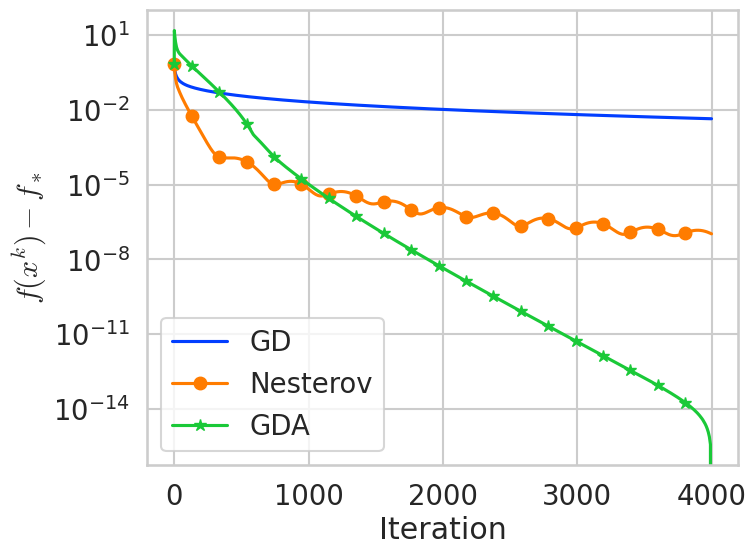

In [22]:
optimizers = [gd, nest, gda1]
markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
labels = ['GD', 'Nesterov', 'GDA']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()


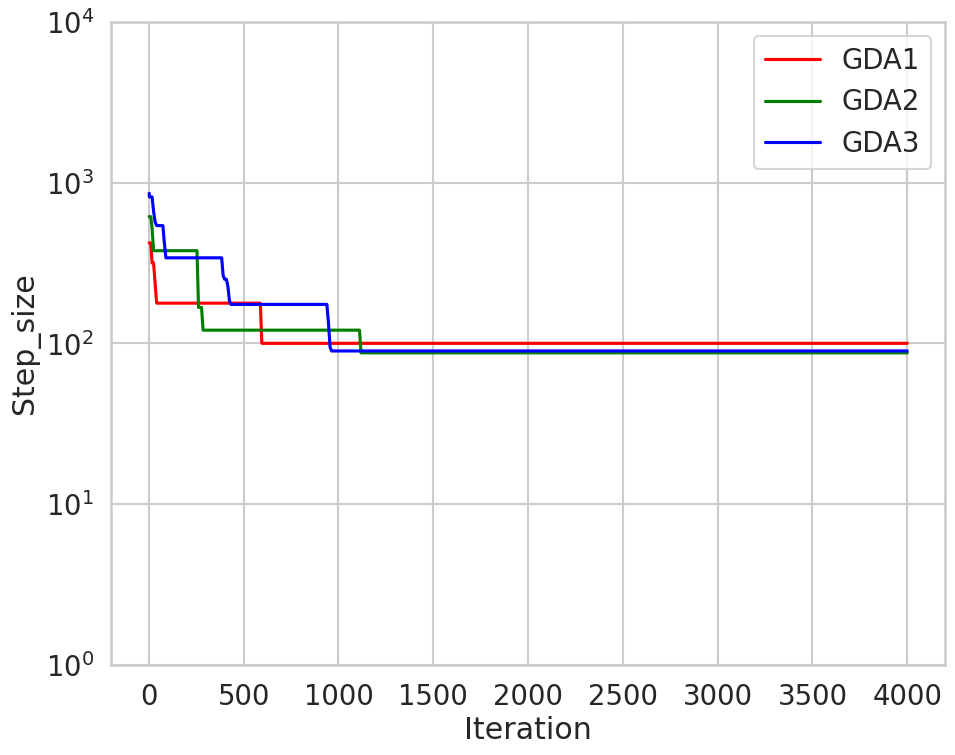

In [23]:

fig, ax = plt.subplots(figsize=(10, 8))
# plt.figure(figsize=(10, 8))
plt.yscale('log')

ax.set_ylim(bottom=1, top=1e4)
my_green = sns.color_palette('bright')[2]
plt.xlabel('Iteration')
plt.ylabel(r'Step_size')
# plt.plot(adgd.its[2:], 1/L*np.ones(498), label='1/L', color='black')
# plt.plot(adgd.its[2:], 1/l2*np.ones(498), label=r'1/$\mu$')
# plt.plot(adgd.its[2:], adgd.lrs[2:], label='Adgd', color=my_green)
plt.plot(gda1.its[2:], gda1.lrs[2:], label='GDA1', color='red')
plt.plot(gda2.its[2:], gda2.lrs[2:], label='GDA2', color='green')
plt.plot(gda3.its[2:], gda3.lrs[2:], label='GDA3', color='blue')
plt.legend()
plt.tight_layout()
plt.show()
# print(len(gda.its))